# PART II: MODELING

- Introduction to Machine Learning
- Models for Classification
  - Logistic regression
  - SVM
  - Decision tree
  - Ensemble methods
- Example: Predicting Hubway User Type
- Advanced Models

In [1]:
# importing libraries
%matplotlib inline
import matplotlib
import pandas as pd # package for data analysis, reading in the data, summarizing data, manipulating data
import numpy as np # package for math operations
import matplotlib.pyplot as plt # package for plotting
from IPython.display import Image
import itertools
from math import radians, cos, sin, asin, sqrt
from sklearn import preprocessing, metrics, model_selection, linear_model, ensemble, svm, tree

In [14]:
# setting up variables for later computation
current_year = 2017.
rand_state = 2
test_size = 0.3

# set random seed
np.random.seed(rand_state)

# funtion to convert birth date to age
year_to_age = lambda s: 0 if 'N' in s else 2017 - int(s)

# function to convert long/lat to distance from Boston City Center
def haversine(pt, lat2=42.355589, lon2=-71.060175):
    lon1 = pt[0]
    lat1 = pt[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles
    return c * r

#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='blue')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='red', alpha=0.3)
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Blues')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

# function to generate some toy data for classification
def generate_toy_data(test_size, rand_state):
    data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
    data = np.hstack((data, np.zeros((200, 1))))
    data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], 
                                                                     len(data[data[:, 0]**2 + data[:, 1]**2 < 3**2]), 
                                                                     p=[0.2, 0.8])
    X = data[:, :-1]
    y = data[:, -1]
    
    # train test split
    return model_selection.train_test_split(X, y, test_size=test_size, random_state=rand_state)

In [15]:
# read in ride data
ride_data = pd.read_csv('hubway_data_subset.csv', index_col=0)
# read in station data
station_data = pd.read_csv('hubway_stations.csv', low_memory=False)[['id', 'lat', 'lng']]

In [16]:
# compute age from birth dates
ride_data.loc[:, 'age'] = current_year - ride_data['birth_date'].values
# join longitude/latitude to ride dataframe by the start station id 
ride_data_with_gps = ride_data.join(station_data.set_index('id'), on='strt_statn')
# compute distance from start station to city center 
ride_data.loc[:, 'start_dist_to_center'] = list(map(haversine, ride_data_with_gps[['lng', 'lat']].values))
# join longitude/latitude to ride dataframe by the end station id 
ride_data_with_gps = ride_data.join(station_data.set_index('id'), on='end_statn')
# compute distance from end station to city center 
ride_data.loc[:, 'end_dist_to_center'] = list(map(haversine, ride_data_with_gps[['lng', 'lat']].values))

# WHAT IS MACHINE LEARNING?

Automated learning of rules and patterns from data.

**Supervised vs unsupervised**

Supervised: learning rules from provided examples

<img src="images/supervised1.png" alt="" style="height: 300px;"/>

Supervised: learning rules from provided examples

<img src="images/supervised2.png" alt="" style="height: 300px;"/>

Unsupervised: learning hidden (latent) structures 

<img src="images/unsupervised1.png" alt="" style="height: 300px;"/>

Unsupervised: learning hidden (latent) structures 

<img src="images/unsupervised2.png" alt="" style="height: 300px;"/>

**Regression vs classification**

A common task for supervised learning is to use a observed values of a set of ***predictors***
$$
[x_1, \ldots, x_D] \in \mathbb{R}^D
$$
to predict a quantity of interest $y$, called the ***response***. 

If $y$ is a real-valued variable, we call the task ***regression***, if $y$ is a label (categorical variable) we all the task ***classification***.

**Training**

In supervised learning, when we say we are ***training*** or ***fitting*** a model, we typically mean that
0. We have a set of observations, called ***training data***,
$$
\{(\mathbf{x}_1, y_1),\ldots, (\mathbf{x}_N, y_N)\}
$$
where each $\mathbf{x}_n$ is the observed values of the $D$-number of predictors $\mathbf{x}_n = [x_1, \ldots, x_D]$.
1. We have a 'function' in mind that explains how the response depends on the predictors
$$
f(x_1, \ldots, x_D) \rightarrow y.
$$
2. This function has some constants/coefficients we need to set, these are called ***parameters***, e.g.
$$
f(x_1, \ldots, x_D) = w_1\sin(x_1) + \ldots + w_D \sin(x_D)
$$
3. We find the values of these parameters so to best explain the observed data (e.g. our model should explain what we've seen).
4. To evaluate our model, we use our function to make predictions $\widehat{y}$ and compare them to the true response $y$ in our training data. 

For classification, we will be using ***accuracy***, i.e. the percentage of points correctly labeled by our model.

**Testing**

**Question:** Is it enough to check that we do well on the training data?

**Hint:** remember that you optimized your model to explain the training data.

# MODELS FOR CLASSIFICATION

  - Logistic regression
  - SVM
  - Decision tree
  - Ensemble methods

# Logistic Regression: The Idea

Suppose our data has a small number of predictors, by visualizing the data we can intuitively check how easy it is to separate the classes.
<img src="images/decision_boundary0.png" alt="" style="height: 300px;"/>
Ideally, the classes are easily separated by a curve (or surface) in the input space, this curve (or surface) is called the ***decision boundary***.

We can try to model the **probability** of a data point being from a particular class by
1. which side of the decision boundary it's on
2. how far it is away from the boundary. Intuitively, the farther a data point is from the decision boundary, the more 'certain' we should be of it's classification.

<img src="images/decision_boundary0.png" alt="" style="height: 300px;"/>

# Logistic Regression: Linear Decision Boundary

When the decision boundary is linear, it is defined by the equation
$$
\mathbf{w}^\top \mathbf{x} = w_0x_0 + w_1x_1 + \ldots + w_D x_D = 0
$$
where $x_0 = 1$.

The vector $\mathbf{w}$ allow us to gauge the 'distance' of a point from the decision boundary
<img src="images/decision_boundary1.png" alt="" style="height: 300px;"/>

To model the probability of labeling a point a certain class, we have to convert distance, $\mathbf{w}^\top\mathbf{x}$ (which is unbounded) into a number between 0 and 1, using the ***sigmoid function***:
$$
\text{Prob}[y = 1 | \mathbf{x}] = \text{sigm}(\mathbf{w}^\top\mathbf{x})
$$
If $\text{Prob}[y = 1 | \mathbf{x}]$ we label $\mathbf{x}$ class 1, otherwise we label it class 0.


To *fit* our model, we need to learn the parameters of $\mathbf{w}$ that maximizes the likelihood of our training data.

In [17]:
# read training toy data set
linear_toy_data= pd.read_csv('toy_data_train.txt', delimiter=',')
X_train = linear_toy_data.values[:, :-1]
y_train = linear_toy_data.values[:, -1]
# read testing toy data set
linear_toy_data = pd.read_csv('toy_data_test.txt', delimiter=',')
X_test = linear_toy_data.values[:, :-1]
y_test = linear_toy_data.values[:, -1]

In [18]:
# create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression(C=1.)
# fit our logistic regression model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

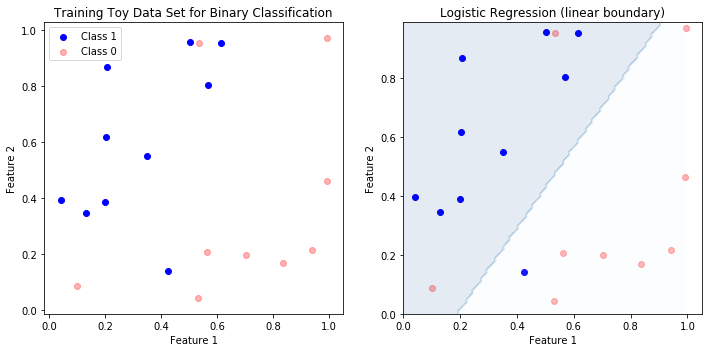

In [19]:
# plot data and decision boundary of logistic regression
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot class 1
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Class 1')
# plot class 0
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='red', label='Class 0', alpha=0.3)
# label axes
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
# label title
ax[0].set_title('Training Toy Data Set for Binary Classification')
# add legend
ax[0].legend()

# plot decision boundary
ax[1] = plot_decision_boundary(X_train, y_train, logreg, 
                               'Logistic Regression (linear boundary)', 
                               ax[1])

plt.tight_layout()
plt.show()

In [20]:
# evaluate model
scores_df = pd.DataFrame(data={'logistic regression': [logreg.score(X_train, y_train), logreg.score(X_test, y_test)]}, 
                         index=['train score', 'test score'])
scores_df.head()

,logistic regression
train score,0.842105
test score,0.835443


**Questions:** Why does the model do worse on testing data rather than training data?

# Logistic Regression: Non-Linear Decision Boundary

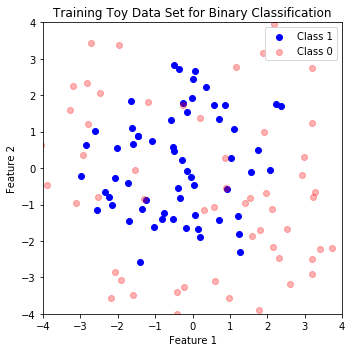

In [24]:
# generate more complicated toy data
X_train, X_test, y_train, y_test = generate_toy_data(test_size, rand_state)

# plot data and decision boundary of logistic regression
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# plot class 1
ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Class 1')
# plot class 0
ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='red', label='Class 0', alpha=0.3)
# label axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
# label title
ax.set_title('Training Toy Data Set for Binary Classification')
# add legend
ax.legend()
# add x, y limits
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])

plt.tight_layout()
plt.show()

A simple non-linear boundary is a quadratic decision boundary. It is defined by the equation
$$
\mathbf{w}^\top \mathbf{x}_{\text{poly}} = w_0 + w_{11}x_1 + w_{12}x^2_1 + \ldots + w_{D1}x_D + w_{D2} x^2_D = 0
$$
where $\mathbf{x}_{\text{poly}} = [1, x_1, x^2_1, \ldots, x_D, x^2_D]$.

What the above is saying is that a quadratic equation in $\mathbf{x}$ is **secretly a linear equation** in the transformed vector $\mathbf{x}_{\text{poly}}$.

Computing p-powers of the features:
$$
\begin{aligned}
\mathbb{R}^D &\to \mathbb{R}^{D\cdot p}\\
[x_1, \ldots, x_D] &\rightarrow [x_1, x^2_1\ldots, x^p_1, \ldots, x_D, x^2_D\ldots, x^p_D]
\end{aligned}
$$

<img src="images/poly_features.jpg" alt="" style="height: 80px;"/>

In [21]:
# create polynomial features
quad_features = preprocessing.PolynomialFeatures(degree=2)
X_train_quad = quad_features.fit_transform(X_train)
X_test_quad = quad_features.fit_transform(X_test)
# fit our logistic regression model with non-linear decision boundary
logreg.fit(X_train_quad, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

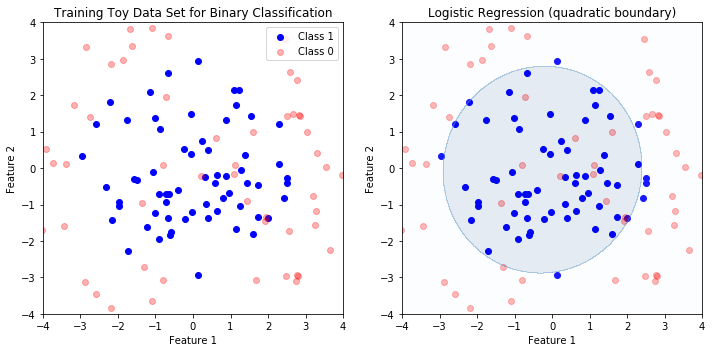

In [22]:
# plot data and decision boundary of logistic regression
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot class 1
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Class 1')
# plot class 0
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='red', label='Class 0', alpha=0.3)
# label axes
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
# label title
ax[0].set_title('Training Toy Data Set for Binary Classification')
# add legend
ax[0].legend()
# set x, y limits
ax[0].set_xlim([-4, 4])
ax[0].set_ylim([-4, 4])

# plot decision boundary
ax[1] = plot_decision_boundary(X_train, y_train, logreg, 
                               'Logistic Regression (quadratic boundary)', 
                               ax[1], bounds=(-6, 7), poly_flag=True)
# set x, y limits
ax[1].set_xlim([-4, 4])
ax[1].set_ylim([-4, 4])

plt.tight_layout()
plt.show()

In [23]:
# evaluate model
scores_df = pd.DataFrame(data={'logistic regression': [logreg.score(X_train_quad, y_train), logreg.score(X_test_quad, y_test)]}, 
                         index=['train score', 'test score'])
scores_df.head()

,logistic regression
train score,0.871429
test score,0.816667


# Support Vector Classifiers (SVC)

Another way to use a decision boundary for classification is to build a Support Vector Classifier. 

1. Logistic regression: 
  - uses the decision boundary to model the **probability** of labeling a point a certain class
  - maximizes the likelihood of the training set

2. Support vector classifier: 
  - classifies points on one side of boundary as one class and the other side of the boundary the other class
  - maximizes the distance between the points and the boundary, while minimizing the number of misclassifications

Recall from building logistic regression with quadratic boundaries: the key observation is that training a polynomial model is just training a linear model on data with transformed predictors. 

In our previous example, transforming the data to fit a 2nd degree polynomial model requires a map
\begin{aligned}
&\phi: \mathbb{R} \to \mathbb{R}^3\\
&\phi(x) = (x^0, x^1, x^2)
\end{aligned}
where $\mathbb{R}$ called the ***input space***, $\mathbb{R}^3$ is called the ***feature space***. 

While the data may not be linearly separable in the input space, it may be in the feature space.
<img src="images/feature_space.png" alt="" style="height: 300px;"/>

**The Kernel Trick:** since the feature space can extremely high dimensional, computing $\phi$ explicitly can be costly. 

Instead, we note that computing $\phi$ is unnecessary. For training a (support vector) classifier we just need to compute the inner products of vectors in feature space, this inner product is called ***the kernel function***.

**For Practitioners:**

A support vector classifier model, as implemented in `sklearn`, has several 'customizations' that affect model performance:

1. a choice of the kernel function (i.e. a choice of the map $\phi$ of the input into some feature space)
2. for each kernel function, a number of constants (hyper-parameters)

# Decision Trees

Logistic regression models with linear boundaries are intuitive to interpret. We often examine the impact of each predictor on the log-odds of a positive classification:
$$
12 x_1 - 0.4 x_2 + -20x_3 = 0.
$$


But it is less straightforward to interpret nonlinear decision boundaries in the problem context:
$$
(x_3 + 2 x_2)^2 - x_1 + 10 = 0.
$$

It would be desirable to build models with complex decision boundaries that are also easy to interpret.

But people in every walk of life have long been using ***decision trees*** (flow charts) for differentiating between classes of objects and phenomena:
<img src="images/dt_partition.png" alt="" style="height: 300px;"/>
Every flow chart tree corresponds to a partition of the input space by axis aligned lines or (hyper) planes.

Conversely, every such partition can be written as a flow chart tree.

**Fitting a decision tree on training data:**

1. Start with an empty decision tree (undivided feature space)
2. Choose the 'optimal' predictor on which to split and choose the 'optimal' threshold value for splitting.
3. Recurse on on each new node until some stopping condition is met

Typically, we measure optimality by the purity (in terms of observed clases) of each region defined by the tree.

We usually stop until a pre-defined maximum depth is reached.

**For Practitioners:**

A decision tree model, as implemented in `sklearn`, has several hyper-parameters. Two important ones being:

1. stopping condition (usually the max depth, but can also be minimum number of observations per region defined by tree)
2. splittin condition (what criteria of purity, in terms of observed classes, used to determine an 'optimal' split)

**Deep vs Shallow Trees**

<img src="images/dt_bias.png" alt="" style="height: 500px;"/>

***Exercise:*** implement decision trees of various depth on the toy data set with non-linear boundary. What is the depth you need to get a 'good' fit?

**Deep vs Shallow Trees**
If you randomly draw 50 sample from our toy data with non-linear boundary and fit a decision tree on each sample individually, their decision boundaries will look like the following:

<img src="images/dt_var.png" alt="" style="height: 300px;"/>

***Exercise:*** plot the training score and the testing score as a function of the depth of the decision tree. What do you observe?

# Ensemble Methods: Bagging (Random Forest)

As we've seen:

1. a shallow decision tree is often unable to capture complex decision boundaries (high bias)
2. a deep decision tree tends to be overly sensitive to the noise the training data leading to overfitting (high variance)

A compromise for reducing variance is to fit a large number of sensitive models (deep trees) on the training data and then average the results (reducing the variance).

<img src="images/random_forest.jpg" alt="" style="height: 300px;"/>

A random forest is the 'averaged model' of collection of deep decision trees each learned on a subset of the training data (each branch in each tree is also trained on a randomized set of input dimensions to reduce correlation between trees).

**For Practitioners:**

A random forest, as implemented in `sklearn`, has a number of hyper-parameters that effects model performance. Some important hyper-parameters are:

1. number of trees in the forest
2. max depth of trees
3. hyper-parameters that determines the subsets of input dimensions to learn each branch and the subsets of training data to learn each tree

# Ensemble Methods: Boosting (AdaBoost)

Instead of 'averaging' over a large number of complex models (to reduce variance or overfitting), we can aggregate a large number of simple models into a complex model (to overcome high bias).

Each model $T_h$ might be a poor fit for the data, but a linear combination of the ensemble
$$
T = \sum_h \lambda_h T_h
$$
can be expressive.

***Gradient boosting*** is a method for iteratively building a complex regression model $T$ by adding simple models. Each new simple model added to the ensemble compensates for the weaknesses of the current ensemble.

1. We start by fitting a simple model $T^{(0)}$ on the training data, $\{(x_1, y_1),\ldots, (x_N, y_N)\}$.
2. Compute the ***residuals*** or errors $\{r_1, \ldots, r_N\}$ for $T$
3. Fit a simple model $T^{(i)}$ to models the errors of $T$
4. Set $T\leftarrow T + \lambda T^{i}$


Intuitively, with each addition of $T^{(i)}$, the error is reduced 

Note that gradient boosting has a hyper-parameter, $\lambda$. This is called the ***learning rate***.

Gradient boosting is in fact gradient descent, with the objective of minimizing model error:

<img src="images/descent.png" alt="" style="height: 300px;"/>

**For Practitioners:**

All of this formalism is to say that ***it is important to choose a good learning rate***!


<img src="images/learning_rate.png" alt="" style="height: 300px;"/>

# EXAMPLE: CLASSIFICATION WITH REAL DATA

##  Predicting Hubway User Types
### Using Two Covariates:
- **Simple Covariates:** Trip duration, check-out hour
- **Response:** 1 for subscriber, 0 for non-subscribe
- **Models:** Logistic regression (linear boundary), SVM (RBF kernel), Random Forest, AdaBoost

In [29]:
# define covariates: duration, checkout hour, gender, age, distance from start station to city center, 
# distance from end station to city center
X = ride_data[['duration', 'check_out_hour']]
X_expanded = ride_data[['duration', 'check_out_hour', 'start_dist_to_center', 'end_dist_to_center']].fillna(0)

# define response variable as subscriber type: 1 for subscriber, 0 for non-subscriber
y = ride_data['subsc_type']

In [30]:
# train test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values, test_size=test_size, random_state=rand_state)

# standardize the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# list of model names
methods = ['logistic', 'svm', 'tree', 'RF', 'AdaBoost']
# list of model for classification
models = [linear_model.LogisticRegression(C=10, random_state=rand_state), 
          svm.SVC(C=1, gamma=0.5, random_state=rand_state), 
          tree.DecisionTreeClassifier(max_depth = 20, random_state=rand_state), 
          ensemble.RandomForestClassifier(n_estimators=50, random_state=rand_state), 
          ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2), 
                                      n_estimators=50, random_state=rand_state, learning_rate=1e-1)]
# apply models to our data
scores = {}
for i in range(len(methods)):
    models[i].fit(X_train, y_train)
    scores[methods[i]] = [models[i].score(X_train, y_train), models[i].score(X_test, y_test)]
# compare results
scores_df = pd.DataFrame(data=scores, index=['train score', 'test score'])
scores_df.head()

,AdaBoost,RF,logistic,svm,tree
train score,0.764286,0.997143,0.658571,0.662857,0.962857
test score,0.693333,0.653333,0.716667,0.680000,0.620000


##  Predicting Hubway User Types
### Using Four Covariates:
- **Simple Covariates:** Trip duration, check-out hour, distance between start and end stations from city center
- **Response:** 1 for subscriber, 0 for non-subscribe
- **Models:** Logistic regression (linear boundary), SVM (RBF kernel), Random Forest, AdaBoost

In [32]:
# train test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_expanded.values, y.values, test_size=test_size, random_state=rand_state)

# standardize the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# apply models to our data
scores = {}
for i in range(len(methods)):
    models[i].fit(X_train, y_train)
    scores[methods[i]] = [models[i].score(X_train, y_train), models[i].score(X_test, y_test)]
# compare results
scores_df = pd.DataFrame(data=scores, index=['train score (expanded covariates)', 'test score(expanded covariates)'])
scores_df.head()

,AdaBoost,RF,logistic,svm,tree
train score (expanded covariates),0.767143,1.000000,0.665714,0.697143,0.975714
test score(expanded covariates),0.706667,0.673333,0.690000,0.653333,0.676667


# Lingering Questions:

-  You will notice that the train/test score of the various models are affected by the values of the hyper-parameters as well as the train/test split.
   - How do we determine the "best" hyper-parameters? Should we pick ones that maximizes the test score?
   - How do we compare the performance of the various models in a fair way? Maybe the high performing models just got lucky with this particular test set?
- Is accuracy (percent of data correctly classified) a good measure for evaluating the performance of a classifier? Can you think of a situation where accuracy can be misleading?

We will explore answers to these questions in Part III: Model Evaluation.